In [1]:
%load_ext tikzmagic

---
slug: "/blog/ensemblelearning"
date: "2021-03-15"
title: "Ensemble Learning"
category: "1 Machine Learning"
order: 6
---

### Introduction

Ensemble learning is the process of using multiple models to improve overall performance in a machine learning tasks.
This post briefly touches on two popular ensemble methods for decision tree learners: Random Forests and Gradient Boosted Trees.
Random forests are a bagging approach, in which models are trained independently of each other and combined to produce output.
Gradient Boosted Trees are a boosting approach, in which models are trained iteratively, each successive model being trained with regard to the errors of the last.
This post will discuss only the classification version of each - although both approaches can be used for regression as well.

### Random Forests

The basic approach to creating random forests is shown in the pseudo-code below.
A bootstrap sample is drawn from data set $X$ of size $N$ with dimension $D$.
A decision tree is built on this bootstrap and added to the ensemble. 
This is repeated $T$ times, $T$ being a model parameter indicating the number of trees to include in the ensemble.
This post will also consider the maximum depth of each tree and the minimum size of a leaf as parameters of the Random Forest model.

``` 
for t = 1 to T:
   Retrieve a bootstrap sample
   Grow a full decision tree on the sample with random features
   Add it to the ensemble
       
return ensemble           
```

Given a trained random forest, outputs are produced by taking the majority output class of all decision trees in the ensemble.

$$
\begin{aligned}
    m_t &= \text{model $t$ of the ensemble} &\\
    f(x) &= \text{majority vote}\{m_t(x)\}^T_{t=1} & \text{[Output]}\\ 
\end{aligned}
$$

### Code

Code for a random forest classifier is shown in the block below.
It assumes use of the decision tree classifier class described in the earlier post on decision trees.

In [2]:
from mlr.Models.DecisionTree import DecisionTreeClassifier 
from typing import List
from tqdm import trange
import torch


class RandomForestClassifier:


    def __init__(self, numTrees: int=5, maxDepth: int=None, leafSize: int=1, bootstrapRatio: float=0.3) -> None:
        """ Instantiate random forest classifier

        Args:
            numTrees: number of trees to build
            maxDepth: the maximum allowed depth of each tree
            leafSize: the minimum number of data points required to split a node 
            bootstrapRatio: ratio of training data to use for each bootstrap
        """
        self.forest = []
        self.numTrees = numTrees
        self.maxDepth = maxDepth
        self.leafSize = leafSize
        self.bootstrapRatio = bootstrapRatio


    def fit(self, x: torch.Tensor, y: torch.Tensor, classes: List[float]) -> None:
        """ Fit random forest model to dataset

        Args:
            x: input data
            y: input labels
            classes: list of unique possible labels
        """

        for i in trange(self.numTrees):
            
            # Create bootstrap sample
            rargs = torch.randperm(x.shape[0]) 
            x, y = x[rargs], y[rargs] 
            bidx = int(x.shape[0] * self.bootstrapRatio)

            tree = DecisionTreeClassifier(maxDepth=self.maxDepth, leafSize=self.leafSize)
            tree.fit(x[:bidx], y[:bidx], classes)
            self.forest.append(tree)


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict outcomes given input

        Args:
            x: input data

        Returns:
            tensor of class labels            
        """

        return torch.mode(
            torch.cat(
                [tree.predict(x) for tree in self.forest], dim=1
            ), dim=1
        ).values[:, None]


### Gradient Boosted Trees

The basic approach to creating gradient boosted trees is shown in the pseudo-code below.
A shallow decision tree is trained on data set $X$ of size $N$ with dimension $D$. 
The following decision tree is trained on the negative gradient on a chosen loss function.
In this post, cross entropy will be used as a loss function, and the number of decision trees in the ensemble, the maximum depth of each tree, and the minimum size of a leaf will all be considered parameters of the model.
The softmax function is used to account for multiclass classification problems.
Decision tree regressors are used internally, even though the ensemble itself is a classifier

```
fit tree to data
calculate gradient

while loss not acceptable:
    fit new tree to negative gradient
    calculate gradient
```

The following computation graph provides some insight into how gradients are calculated in the model update process. 
Outputs $o_1 .. o_k$, probabilities for each of $K$ classes are produced by a single internal decision tree regressor.
The softmax function is performed on this vector $\vec{o}$ to produce $\vec{p}$. 
The loss is then calculated using $\vec{p}$ and $\vec{y}$.
The gradient is calculated with respect to model outputs $o_1$ to $o_k$.

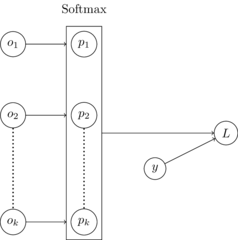

In [3]:
%%tikz s=400,400 -sc=2
\node[draw, circle] (o1) at (0, 0) {$o_1$};
\node[draw, circle] (o2) at (0, -1) {$o_2$};
\node[draw, circle] (ok) at (0, -2.5) {$o_k$};
\node[draw, circle] (p1) at (1, 0) {$p_1$};
\node[draw, circle] (p2) at (1, -1) {$p_2$};
\node[draw, circle] (pk) at (1, -2.5) {$p_k$};
\node[draw, circle] (y) at (2, -1.75) {$y$};
\node[draw, circle] (l) at (3, -1.25) {$L$};
\node (sm) at (1, 0.5) {Softmax};
\draw (0.75, 0.25) rectangle (1.25, -2.75);
\draw[dotted, line width=1pt] (o2) -- (ok);
\draw[dotted, line width=1pt] (p2) -- (pk);
\draw[->] (o1) -- (0.75, 0);
\draw[->] (o2) -- (0.75, -1);
\draw[->] (ok) -- (0.75, -2.5);
\draw[->] (y) -- (l);
\draw[->] (1.25, -1.25) -- (l);

Once trained, the ensemble produces output by adding up the outputs produced by all the internal decision tree regressors, and taking the class with the maximum probability as the output label.
Derivations for the model update are shown in the derivations section of this post.

$$
\begin{aligned}
    s(x_i) &= \frac{e^{x_i}}{\sum^{K}_{k=1} e^{x_k}} & \text{[Softmax function]}\\
    L(y, \hat{y}) &= - \left[ \sum^{K}_{k=1} y_k\log \hat{y}_k \right] & \text{[Cross entropy loss]}\\
    f(x) &= \max_k\left[\sum^T_{t=1} f_t(x)\right] & \text{[Output]}\\
    f(x) &= f(x) - \alpha \frac{\partial L}{\partial f(x)} & \text{[Model update]}\\
    &= f(x) - \alpha \left[ s(f(x) - y) \right]&\\
\end{aligned}
$$

### Code

Code for a gradient boosted trees classifier is shown in the block below.
It assumes use of the decision tree regressor class described in the earlier post on decision trees.

In [4]:
from mlr.Models.DecisionTree import DecisionTreeRegressor 
from typing import List
from tqdm import trange
import numpy as np
import torch


def createOneHotColumn(data: np.ndarray, colidx: int=0) -> (np.ndarray, np.ndarray):
    """ Turn single categorical column to one-hot columns

    Args:
        data: input data
        colidx: column to transform

    Returns:
        one-hot vectors of specified column
        list of column names for new one-hot vectors 
    """

    ucols = np.unique(data[:, colidx])
    uidxs = { ucols[i]: i for i in range(len(ucols)) }
    urows = np.zeros((data.shape[0], ucols.shape[0]))

    for ridx in range(data.shape[0]):
        urows[ridx, uidxs[data[ridx, colidx]]] = 1.0

    return urows, ucols        


def Softmax(x: torch.Tensor) -> torch.Tensor:
    """ Apply softmax function to tensor

    Args:
        x: input tensor

    Returns:
        tensor with softmax function applied to all members
    """

    return torch.exp(x) / torch.sum(torch.exp(x), dim=1)[:, None]


class GradientBoostedTreeClassifier:


    def __init__(self, maxDepth: int=3, leafSize: int=1):
        """ Initializes GradientBoostedTreeClassifier class

        Args:
            maxDepth: maximum depth of internal trees
            leafSize: minimum size of node for each tree
        """
        self.maxDepth = maxDepth
        self.leafSize = leafSize
        self.layers = []


    def fit(self, x: torch.Tensor, y: torch.Tensor, alpha: float=0.01, numTrees: int=10) -> None:
        """ Fit classifier to input data

        Args:
            x: input data
            y: input labels
            alpha: alpha parameter for weight update
        """

        y = torch.Tensor(createOneHotColumn(y.numpy())[0])
        self.numClasses = y.shape[1]
        ypred = torch.full(y.shape, 1 / y.shape[1])

        layers, fx = [], y - ypred
        for i in trange(numTrees):

            trees = [ DecisionTreeRegressor(maxDepth=self.maxDepth, leafSize=self.leafSize) for i in range(y.shape[1]) ]
            for i in range(len(trees)): 
                trees[i].fit(x, fx[:, i])

            layers.append(trees)

            probs = self.probs(x, trees)
            fx -= alpha * (probs - y)

        self.layers = layers


    def probs(self, x: torch.Tensor, trees: List[DecisionTreeRegressor]) -> torch.Tensor:
        """ Determine probability of belonging to each class

        Args:
            x: input data
            trees: list of decision trees, one for each class

        Returns:
            probability for each input
        """

        probs = [trees[i].predict(x)[:, None] for i in range(len(trees))]
        return Softmax(torch.cat(probs, dim=1))


    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict labels

        Args:
            x: input data

        Returns:
            labels for each member of input
        """

        ypred = torch.zeros((x.shape[0], self.numClasses))
        for trees in self.layers:
            probs = self.probs(x, trees)
            ypred += probs

        return torch.argmax(ypred, dim=1)[:, None]



### Derivations

Derivative of softmax output $p_j$ with respect to single $f(x)$ output $o_i$ to:

$$
\begin{aligned}
    \frac{\partial p_j}{\partial o_j} &= \frac{\partial}{\partial o_i} \frac{e^{o_j}}{\sum^K_{k=1} e^{o_k}} \\
    &= \frac{ (\frac{\partial}{\partial o_i} e^{o_j})(\sum^K_{k=1} e^{o_k}) - (e^{o_j})(\frac{\partial}{\partial o_i} \sum^K_{k=1} e^{o_k}) }{ (\sum^K_{k=1} e^{o_k})^2 }\\
    &= \begin{cases} i = j & \frac{ e^{o_j} \sum^K_{k=1}e^{o_k} - (e^{o_j})^2 }{ (\sum^K_{k=1}e^{o_k})^2 }\\ i \neq j & \frac{ 0 - e^{o_j}e^{o_i} }{ (\sum^K_{k=1}e^{o_k})^2 }\\ \end{cases}\\
    &= \begin{cases} i = j & p_j - p_j^2\\ i \neq j & -p_jp_i\\ \end{cases}\\
\end{aligned}
$$

Derivative of loss $L$ with with respect to single $f(x)$ output $o_i$ to:

$$
\begin{aligned}
    \frac{\partial L}{\partial o_i} &= \frac{\partial}{\partial o_i} \left[- \sum^K_{k=1} y_k \log p_k \right]\\
    &= - \left[\sum^K_{k=1} \frac{\partial}{\partial o_i} y_k \log p_k \right]\\
    &= - \left[\sum^K_{k=1} \frac{y_k}{p_k} \frac{\partial}{\partial o_i}  p_k \right]\\
    &= - \left[ \frac{y_i (p_i - p_i^2)}{p_i} + \sum^K_{k\neq i} \frac{-y_k(p_kp_i)}{p_k} \right]\\
    &= - \left[ y_i (1-p_i) - \sum^K_{k\neq i} y_k p_i \right]\\
    &= - \left[ y_i - p_iy_i - p_i\sum^K_{k\neq i} y_k \right]\\
    &= - \left[ y_i - p_i\sum^K_{k=1} y_k \right]\\
    &= - \left[ y_i - p_i \right]\\
    &=  p_i - y_i\\
\end{aligned}
$$

### Resources
- Russell, Stuart J., et al. Artificial Intelligence: A Modern Approach. 3rd ed, Prentice Hall, 2010.
- Bendersky, Eli. “The Softmax Function and Its Derivative.” Eli Bendersky’s Website. 2016. https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/. Accessed 17 Mar. 2021.
- Liu, Ethen. Gradient Boosting Machine (GBM). http://ethen8181.github.io/machine-learning/trees/gbm/gbm.html. Accessed 17 Mar. 2021.